In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-detection-fer/test/fearful/im292.png
/kaggle/input/emotion-detection-fer/test/fearful/im1022.png
/kaggle/input/emotion-detection-fer/test/fearful/im633.png
/kaggle/input/emotion-detection-fer/test/fearful/im934.png
/kaggle/input/emotion-detection-fer/test/fearful/im927.png
/kaggle/input/emotion-detection-fer/test/fearful/im966.png
/kaggle/input/emotion-detection-fer/test/fearful/im662.png
/kaggle/input/emotion-detection-fer/test/fearful/im648.png
/kaggle/input/emotion-detection-fer/test/fearful/im178.png
/kaggle/input/emotion-detection-fer/test/fearful/im817.png
/kaggle/input/emotion-detection-fer/test/fearful/im308.png
/kaggle/input/emotion-detection-fer/test/fearful/im623.png
/kaggle/input/emotion-detection-fer/test/fearful/im651.png
/kaggle/input/emotion-detection-fer/test/fearful/im72.png
/kaggle/input/emotion-detection-fer/test/fearful/im229.png
/kaggle/input/emotion-detection-fer/test/fearful/im444.png
/kaggle/input/emotion-detection-fer/test/fearful/im415.p

In [2]:
#needed Libraries
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam 
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve,precision_score, recall_score, f1_score,  accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import shutil

#inceptionV3 is a pre-trained model (meaning it has already learned general patterns by training on millions of images)

In [3]:
#load it(local)  while keeping the initial layers frozen (unchanged):
#Define the local path to the weights file
weights_path = '/kaggle/input/inceptionv3-weights-h5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load the InceptionV3 model with local weights and set layers to be non-trainable
base_model = InceptionV3(weights=weights_path, include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # This freezes the layers

In [4]:
#now adding a few layers on top of InceptionV3 so that it learns to recognize emotions
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduces the dimensions of the output
x = Dense(256, activation='relu')(x)  # Adds a dense layer with 256 units
x = Dropout(0.5)(x)  # Adds dropout to prevent overfitting
output = Dense(7, activation='softmax')(x)  # Output layer for 7 emotion classes

# Create the model
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [5]:
#data prep 
# Paths to the dataset directories
original_train_dir = '/kaggle/input/emotion-detection-fer/train'
original_test_dir = '/kaggle/input/emotion-detection-fer/test'

# Paths for new directories after the split (Writable directories)
new_train_dir = '/kaggle/working/new_train'
new_val_dir = '/kaggle/working/new_val'
test_dir = original_test_dir  # Keep the original test set as is

# Create directories if they do not exist
os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_val_dir, exist_ok=True)

# Split the original training set into a new training set (80%) and validation set (20%)
for emotion in os.listdir(original_train_dir):
    emotion_path = os.path.join(original_train_dir, emotion)
    
    # Create emotion folders in the new training and validation directories
    os.makedirs(os.path.join(new_train_dir, emotion), exist_ok=True)
    os.makedirs(os.path.join(new_val_dir, emotion), exist_ok=True)
    
    # Get all images for this emotion
    images = os.listdir(emotion_path)
    
    # Perform 80/20 split
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Move images to the new train and validation directories
    for img in train_images:
        shutil.copy(os.path.join(emotion_path, img), os.path.join(new_train_dir, emotion, img))
        
    for img in val_images:
        shutil.copy(os.path.join(emotion_path, img), os.path.join(new_val_dir, emotion, img))

data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  # Less aggressive rotation
    width_shift_range=0.1,  # Smaller shifts
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],  # Mild brightness adjustment
    shear_range=0.1,
    zoom_range=0.1,  # Slight zoom adjustments
    horizontal_flip=True,
)

#Training
# Callbacks are functions that get called at specific points during training
# They help monitor and control the training process
callbacks = [
    # EarlyStopping: Prevents overfitting by stopping training when the model stops improving
    EarlyStopping(
        monitor='val_loss',          # Watch the validation loss
        patience=5,                  # Wait 5 epochs for improvement before stopping
        restore_best_weights=True    # When stopped, go back to the best model we saw
    ),
    
    # ModelCheckpoint: Saves the model when it improves
    ModelCheckpoint(
        'best_model_stage_1.keras',    # File name to save the model
        monitor='val_accuracy',      # Watch the validation accuracy
        save_best_only=True         # Only save when we get a better accuracy than before
    ),
    
    # ReduceLROnPlateau: Reduces learning rate when model improvement slows
    ReduceLROnPlateau(
        monitor='val_loss',         # Watch the validation loss
        factor=0.2,                 # Multiply learning rate by 0.2 (reduce by 80%)
        patience=3,                 # Wait 3 epochs for improvement before reducing
        min_lr=1e-7                # Don't reduce learning rate below this value
    )
]


# Training and validation data generators
train_data = data_gen.flow_from_directory(
    new_train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = data_gen.flow_from_directory(
    new_val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Test data generator
test_data = data_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle test set
)

Found 22965 images belonging to 7 classes.
Found 5744 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
# 1-Initial Training (only classification head)
history_stage1 = model.fit(
    train_data,                # Training data
    validation_data=val_data,  # Validation data to monitor performance
    epochs=15,                 # Maximum number of epochs 
    callbacks=callbacks        # List of callbacks we defined above
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731718704.461509      99 service.cc:145] XLA service 0x7a424c003c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731718704.461564      99 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/718 ━━━━━━━━━━━━━━━━━━━━ 3:54:00 20s/step - accuracy: 0.1250 - loss: 2.4237

I0000 00:00:1731718713.893084      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


718/718 ━━━━━━━━━━━━━━━━━━━━ 358s 472ms/step - accuracy: 0.2654 - loss: 1.8517 - val_accuracy: 0.3740 - val_loss: 1.6241 - learning_rate: 0.0010
Epoch 2/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 324s 447ms/step - accuracy: 0.3390 - loss: 1.6660 - val_accuracy: 0.3882 - val_loss: 1.5863 - learning_rate: 0.0010
Epoch 3/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 323s 446ms/step - accuracy: 0.3561 - loss: 1.6351 - val_accuracy: 0.3957 - val_loss: 1.5594 - learning_rate: 0.0010
Epoch 4/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 324s 448ms/step - accuracy: 0.3626 - loss: 1.6131 - val_accuracy: 0.4171 - val_loss: 1.5291 - learning_rate: 0.0010
Epoch 5/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 321s 444ms/step - accuracy: 0.3646 - loss: 1.6206 - val_accuracy: 0.3837 - val_loss: 1.5532 - learning_rate: 0.0010
Epoch 6/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 327s 452ms/step - accuracy: 0.3699 - loss: 1.6042 - val_accuracy: 0.4166 - val_loss: 1.5222 - learning_rate: 0.0010
Epoch 7/15
718/718 ━━━━━━━━━━━━━━━━━━━━ 324s 447ms/step - accuracy: 0.3733 

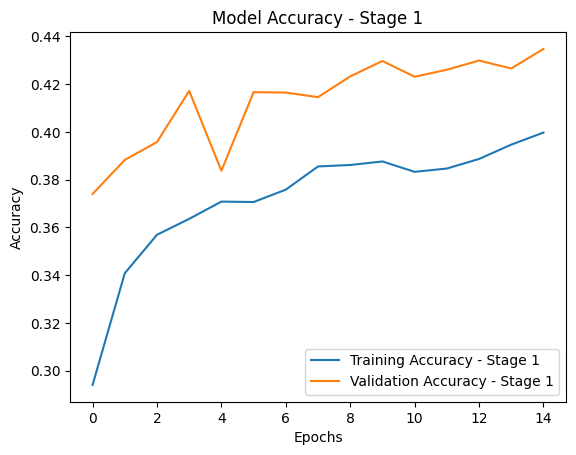

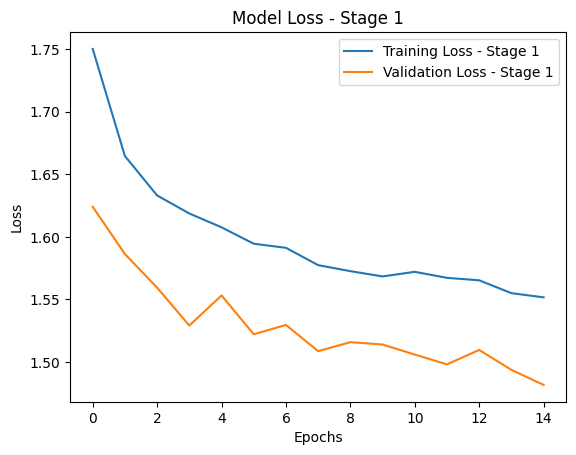

In [7]:
# Visualization for Stage 1
plt.plot(history_stage1.history['accuracy'], label='Training Accuracy - Stage 1')
plt.plot(history_stage1.history['val_accuracy'], label='Validation Accuracy - Stage 1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy - Stage 1')
plt.show()

plt.plot(history_stage1.history['loss'], label='Training Loss - Stage 1')
plt.plot(history_stage1.history['val_loss'], label='Validation Loss - Stage 1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss - Stage 1')
plt.show()


In [8]:
#To unfreeze the last 50% of layers, you must ensure how many roughly half the layers of Inception-V3.
# Total number of layers
total_layers = len(model.layers)
print("Total layers in Inception-V3:", total_layers)

Total layers in Inception-V3: 315


In [9]:
# 2-Fine-tune the model by unfreezing last 50% of layers
for layer in model.layers[:157]:
    layer.trainable = False
for layer in model.layers[157:]:
    layer.trainable = True


# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


# Continue training the model with fine-tuning
history_stage2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
     callbacks=callbacks,
    verbose=1
)

Epoch 1/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 390s 487ms/step - accuracy: 0.4090 - loss: 1.5390 - val_accuracy: 0.5333 - val_loss: 1.2694 - learning_rate: 1.0000e-04
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 327s 452ms/step - accuracy: 0.5118 - loss: 1.3031 - val_accuracy: 0.5693 - val_loss: 1.1607 - learning_rate: 1.0000e-04
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 329s 455ms/step - accuracy: 0.5582 - loss: 1.2092 - val_accuracy: 0.5923 - val_loss: 1.0946 - learning_rate: 1.0000e-04
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 328s 453ms/step - accuracy: 0.5935 - loss: 1.1285 - val_accuracy: 0.6029 - val_loss: 1.0763 - learning_rate: 1.0000e-04
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 325s 450ms/step - accuracy: 0.6038 - loss: 1.0873 - val_accuracy: 0.6170 - val_loss: 1.0282 - learning_rate: 1.0000e-04
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 328s 453ms/step - accuracy: 0.6197 - loss: 1.0432 - val_accuracy: 0.6247 - val_loss: 1.0567 - learning_rate: 1.0000e-04
Epoch 7/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 

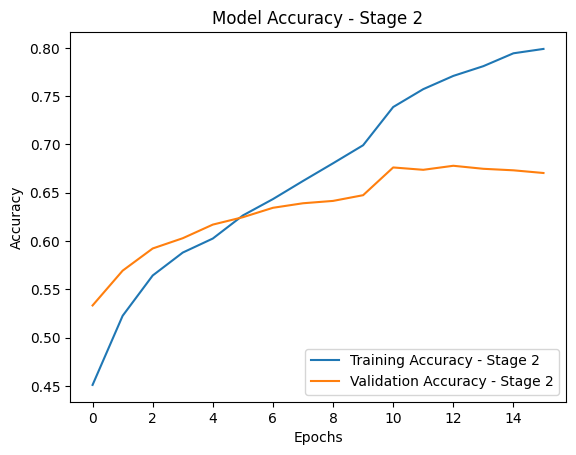

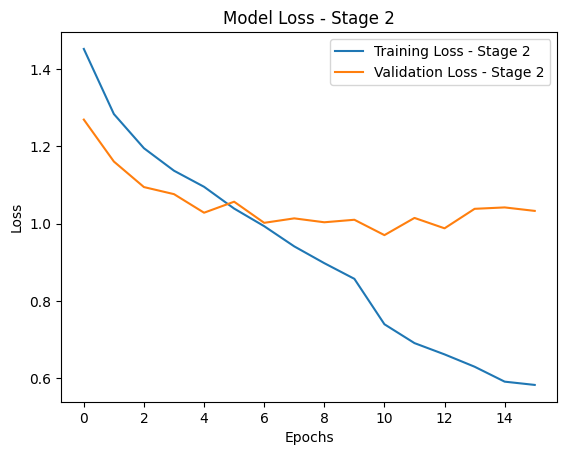

In [10]:
# Visualization for Stage 2
plt.plot(history_stage2.history['accuracy'], label='Training Accuracy - Stage 2')
plt.plot(history_stage2.history['val_accuracy'], label='Validation Accuracy - Stage 2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy - Stage 2')
plt.show()

plt.plot(history_stage2.history['loss'], label='Training Loss - Stage 2')
plt.plot(history_stage2.history['val_loss'], label='Validation Loss - Stage 2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss - Stage 2')
plt.show()


225/225 ━━━━━━━━━━━━━━━━━━━━ 122s 544ms/step - accuracy: 0.6182 - loss: 1.1074
Test Accuracy: 0.6698
Test Loss: 0.9811
225/225 ━━━━━━━━━━━━━━━━━━━━ 94s 395ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.59      0.58      0.59       958
   disgusted       0.74      0.35      0.48       111
     fearful       0.53      0.43      0.47      1024
       happy       0.87      0.87      0.87      1774
     neutral       0.60      0.67      0.64      1233
         sad       0.53      0.58      0.55      1247
   surprised       0.78      0.79      0.78       831

    accuracy                           0.67      7178
   macro avg       0.66      0.61      0.62      7178
weighted avg       0.67      0.67      0.66      7178


Confusion Matrix:
[[ 553    8  103   40   96  139   19]
 [  37   39   21    4    3    6    1]
 [ 104    4  436   28  104  252   96]
 [  30    0   24 1541   94   41   44]
 [  64    1   52   76  832  194   14]
 [ 116 

<Figure size 1000x800 with 0 Axes>

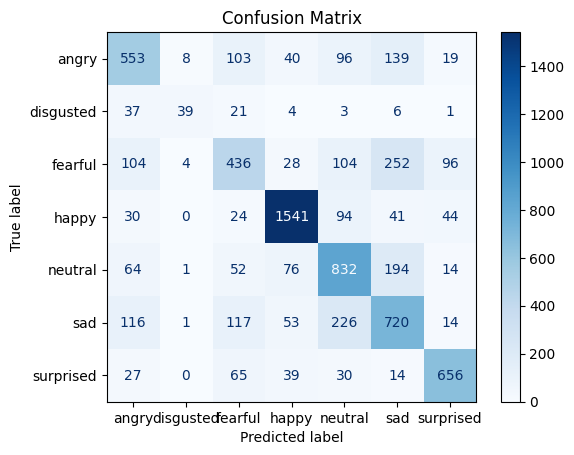

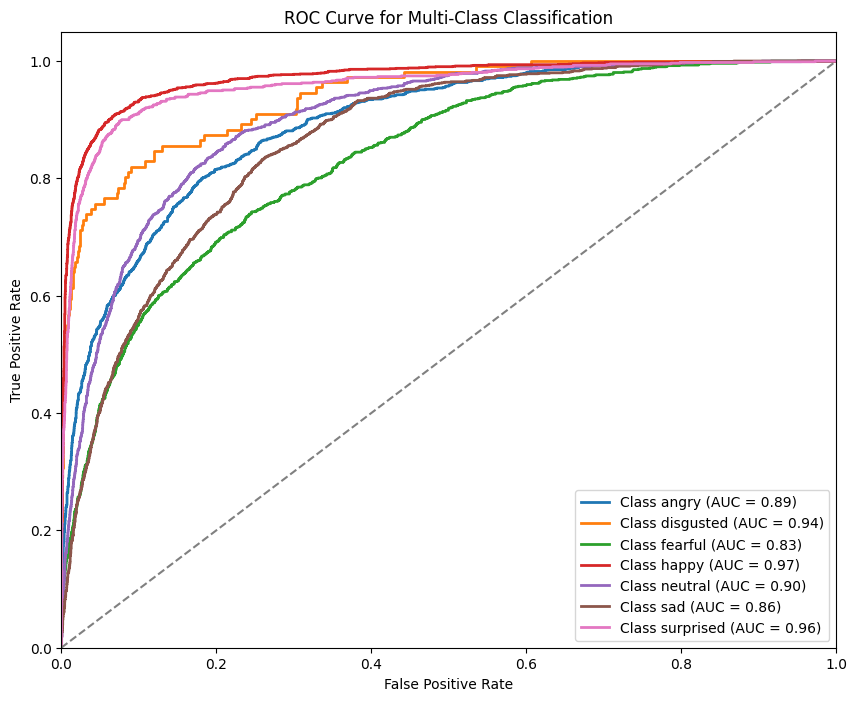

Precision: 0.6653
Recall: 0.6655
F1 Score: 0.6629


In [11]:
#evaluation 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Make predictions on the validation data
predictions = model.predict(test_data, steps=None)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=test_data.class_indices.keys(), zero_division=1))

# Confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_data.class_indices.keys())
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Calculate and Plot ROC Curve for each class
y_true_bin = label_binarize(true_classes, classes=range(len(test_data.class_indices)))  # Binarize true labels
plt.figure(figsize=(10, 8))

# Compute ROC curve and ROC area for each class
for i, label in enumerate(test_data.class_indices.keys()):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Multi-Class Classification")
plt.legend(loc="lower right")
plt.show()

# Additional evaluation
precision = precision_score(true_classes, predicted_classes, average='weighted', zero_division=1)
recall = recall_score(true_classes, predicted_classes, average='weighted', zero_division=1)
f1 = f1_score(true_classes, predicted_classes, average='weighted', zero_division=1)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
